In [1]:
import numpy as np
from rdkit import Chem
from Bio import PDB

In [3]:
ligand = list(Chem.SDMolSupplier('CP_SS_TS/ligand/CP_SS_TS.sdf', sanitize=False))[0]
ligand = Chem.RemoveHs(ligand, sanitize=False)
# ligand_idx = [ 0,  1,  3,  4,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25, 36]
ligand_idx = [1,0,3,6,8]

## Visualize ligand

In [6]:
from rdkit import Chem
from rdkit.Geometry import Point3D
from rdkit.Chem import AllChem

def extract_submolecule_with_positions(mol, atom_indices):
    # Create a new editable molecule
    editable_mol = Chem.RWMol()
    
    # Mapping from old to new atom indices
    old_to_new = {}
    
    # Add the atoms to the new molecule and store their positions
    conf = mol.GetConformer()
    positions = []
    for idx in atom_indices:
        atom = mol.GetAtomWithIdx(idx)
        new_idx = editable_mol.AddAtom(atom)
        old_to_new[idx] = new_idx
        positions.append((new_idx, conf.GetAtomPosition(idx)))
    
    # Convert to a regular molecule
    new_mol = editable_mol.GetMol()
    
    # Create a conformer and set the positions
    new_conf = Chem.Conformer(new_mol.GetNumAtoms())
    for new_idx, pos in positions:
        new_conf.SetAtomPosition(new_idx, Point3D(pos.x, pos.y, pos.z))
    
    new_mol.AddConformer(new_conf)
    
    return new_mol



In [5]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem, Draw

def rotate_molecule(mol, rotation_matrix):
    # Get the conformer
    conf = mol.GetConformer()
    
    # Apply the rotation matrix to each atom's position
    for i in range(mol.GetNumAtoms()):
        pos = np.array(conf.GetAtomPosition(i))
        new_pos = np.dot(rotation_matrix, pos)
        conf.SetAtomPosition(i, new_pos)

# Rotation matrix for rotating 45 degrees around the z-axis
theta = np.radians(30)
c, s = np.cos(theta), np.sin(theta)
rotation_matrix = np.array([
    [c, -s, 0],
    [s, c, 0],
    [0, 0, 1]
])

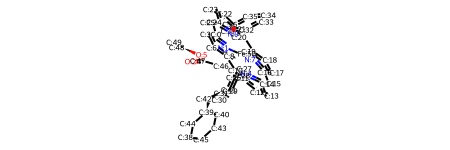

In [7]:
for i, atom in enumerate(ligand.GetAtoms()):
    # For each atom, set the property "molAtomMapNumber" to a custom number, let's say, the index of the atom in the molecule
    atom.SetProp("molAtomMapNumber", str(atom.GetIdx()))

rotate_molecule(ligand, rotation_matrix)
ligand

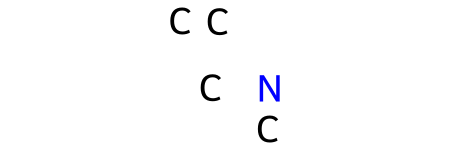

In [82]:
submol = extract_submolecule_with_positions(ligand, ligand_idx)
rotate_molecule(submol, rotation_matrix)
submol

## load ref pdb

In [123]:
pdb_file = 'SMU/7jrq_SMU.pdb'

parser = PDB.PDBParser()
structure = parser.get_structure('complex', pdb_file)

atoms = []
for model in structure:
    for chain in model:
        for residue in chain:
            if not PDB.is_aa(residue):
                ligand_atoms = [atom for atom in residue]
                for atom in ligand_atoms:
                    atoms.append(atom)
                    print(f'Atom: {atom.name}, Coordinates: {atom.coord}')

# ref_idx = range(len(ligand_atoms))
ref_idx = [0,1,2,4,6]

Atom: C1, Coordinates: [  6.473 -20.015  12.388]
Atom: N1, Coordinates: [  6.498 -18.654  12.266]
Atom: C2, Coordinates: [  6.658 -20.375  13.78 ]
Atom: N2, Coordinates: [  6.138 -15.804  11.682]
Atom: C3, Coordinates: [  6.789 -19.23   14.492]
Atom: N3, Coordinates: [  5.628 -16.475   8.851]
Atom: C4, Coordinates: [  6.689 -18.133  13.531]
Atom: N4, Coordinates: [  5.884 -19.285   9.444]
Atom: C5, Coordinates: [  6.777 -16.758  13.858]
Atom: C6, Coordinates: [  6.534 -15.697  12.985]
Atom: C7, Coordinates: [  6.67  -14.28   13.298]
Atom: C8, Coordinates: [  6.347 -13.581  12.208]
Atom: C9, Coordinates: [  6.012 -14.537  11.17 ]
Atom: C10, Coordinates: [  5.612 -14.209   9.863]
Atom: C11, Coordinates: [  5.444 -15.124   8.799]
Atom: C12, Coordinates: [  5.044 -14.721   7.473]
Atom: C13, Coordinates: [  5.    -15.849   6.723]
Atom: C14, Coordinates: [  5.365 -16.959   7.594]
Atom: C15, Coordinates: [  5.449 -18.339   7.206]
Atom: C16, Coordinates: [  5.682 -19.397   8.102]
Atom: C17, Co

## draw ref ligand

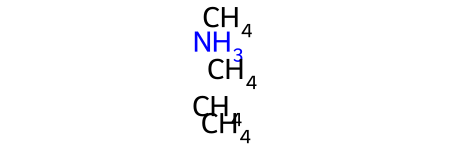

In [124]:
old_to_new = {}
    
editable_mol = Chem.RWMol()
positions = []
atoms = [atom for atom in atoms if atom.element != 'H']
for i, atom in enumerate(atoms):
    if i not in ref_idx:
        continue
    if atom.element == 'FE':
        atom.element = 'Fe'
        new_idx = editable_mol.AddAtom(Chem.Atom(atom.element[:2]))

    elif atom.element == 'MN':
        atom.element = 'Mn'
        new_idx = editable_mol.AddAtom(Chem.Atom(atom.element[:2]))

    else:
        new_idx = editable_mol.AddAtom(Chem.Atom(atom.element[:1]))
    old_to_new[i] = new_idx
    positions.append((new_idx, atom.coord))

# Convert to a regular molecule
new_mol = editable_mol.GetMol()

# Create a conformer and set the positions
new_conf = Chem.Conformer(new_mol.GetNumAtoms())
for new_idx, pos in positions:
    new_conf.SetAtomPosition(new_idx, Point3D(float(pos[0]), float(pos[1]), float(pos[2])))

new_mol.AddConformer(new_conf)
new_mol

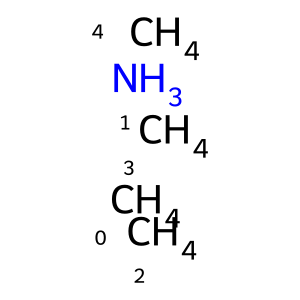

In [125]:
img = Draw.MolToImage(new_mol, legend="Atom Indices")

# Add the atom indices directly on the image
draw = Draw.MolDraw2DCairo(300, 300)
draw.drawOptions().addAtomIndices = True
draw.DrawMolecule(new_mol)
draw.FinishDrawing()
img = draw.GetDrawingText()

# Display the image
with open("molecule_with_indices.png", "wb") as f:
    f.write(img)

from IPython.display import Image
Image(filename="molecule_with_indices.png")

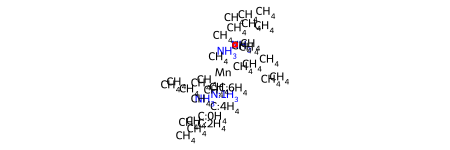

In [122]:
for i, atom in enumerate(new_mol.GetAtoms()):
    # For each atom, set the property "molAtomMapNumber" to a custom number, let's say, the index of the atom in the molecule
    if atom.GetIdx() in [0,1,2,4,6]:
        atom.SetProp("molAtomMapNumber", str(atom.GetIdx()))

rotate_molecule(new_mol, rotation_matrix)
new_mol

## align

In [126]:
from scipy.spatial import distance_matrix
from scipy.optimize import linear_sum_assignment

def kabsch(P, Q):
    """
    The Kabsch algorithm to find the optimal rotation matrix that minimizes
    the RMSD between two sets of points P and Q.
    """
    C = np.dot(np.transpose(P), Q)
    V, S, W = np.linalg.svd(C)
    d = (np.linalg.det(V) * np.linalg.det(W)) < 0.0

    if d:
        S[-1] = -S[-1]
        V[:, -1] = -V[:, -1]

    U = np.dot(V, W)
    return U

pos = ligand.GetConformer().GetPositions()
ref_pos = np.array([atom.coord for atom in atoms if atom.element[:1] != 'H'])
lig_pos = [pos[i] for i in ligand_idx]
pdb_pos = [ref_pos[i] for i in ref_idx]
P = lig_pos - np.mean(lig_pos, axis=0)
Q = pdb_pos - np.mean(pdb_pos, axis=0)

# dist_matrix = distance_matrix(Q, P)
# row_ind, col_ind = linear_sum_assignment(dist_matrix)
# coords2_ordered = P[col_ind]
# U = kabsch(Q, coords2_ordered)

U = kabsch(P, Q)

P = pos - np.mean(lig_pos, axis=0)
sdf_coords_aligned = np.dot(P, U)
# sdf_coords_aligned = sdf_coords_aligned - np.mean(sdf_coords_aligned, axis=0)
sdf_coords_aligned = sdf_coords_aligned + np.mean(pdb_pos, axis=0)

In [127]:
conf = ligand.GetConformer()

for i, (x, y, z) in enumerate(sdf_coords_aligned):
    conf.SetAtomPosition(i, Chem.rdGeometry.Point3D(x, y, z))

In [128]:
def write_pdb(molecule, filename):
    with open(filename, 'w') as f:
        f.write("HEADER    LIGAND\n")
        f.write("TITLE     Aligned Ligand\n")
        
        atom_index = 1
        for atom in molecule.GetAtoms():
            pos = molecule.GetConformer().GetAtomPosition(atom.GetIdx())
            line = (
                f"ATOM  {atom_index:5d} {atom.GetSymbol():>2s}  LIG A   1    "
                f"{pos.x:8.3f}{pos.y:8.3f}{pos.z:8.3f}  1.00  0.00           {atom.GetSymbol():>2s}\n"
            )
            f.write(line)
            atom_index += 1

        f.write("END\n")

pdb_file = '7jrq_CP_SS_TS.pdb'
write_pdb(ligand, pdb_file)

merge with ori protein using pymol \
alter new_CP_SS_TS, type='HETATM' \
alter new_CP_SS_TS, resn='HBA' \
create merged_protein_ligand, 7o2g or new_CP_SS_TS \
save 7o2g_CP_SS_TS.pdb, merged_protein_ligand